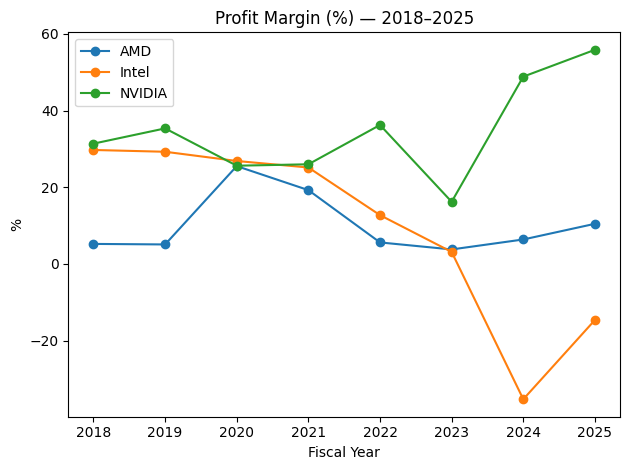

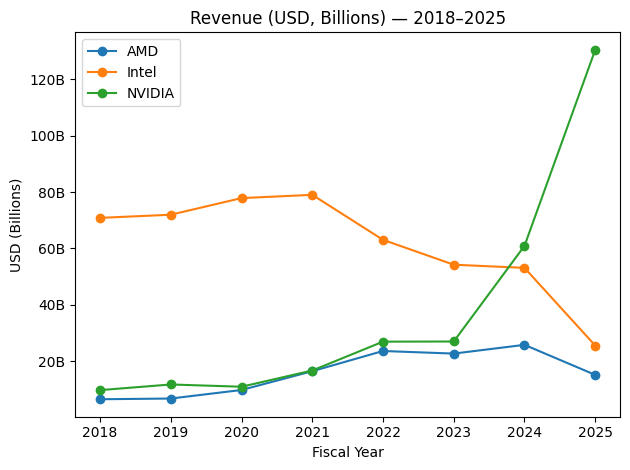

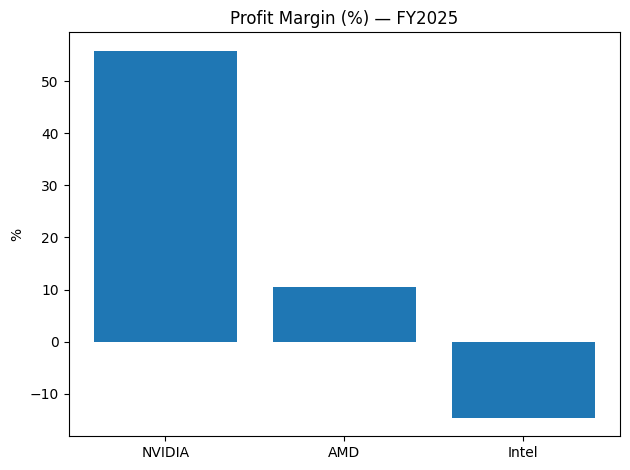

C:\Users\enado\AppData\Local\Temp\ipykernel_5024\1643366449.py:167: RuntimeWarning: invalid value encountered in scalar power
  return (end / start) ** (1/(years-1)) - 1


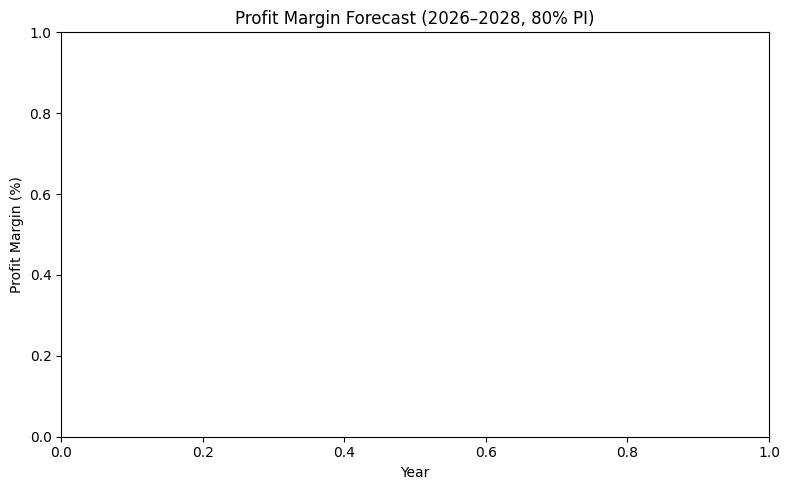

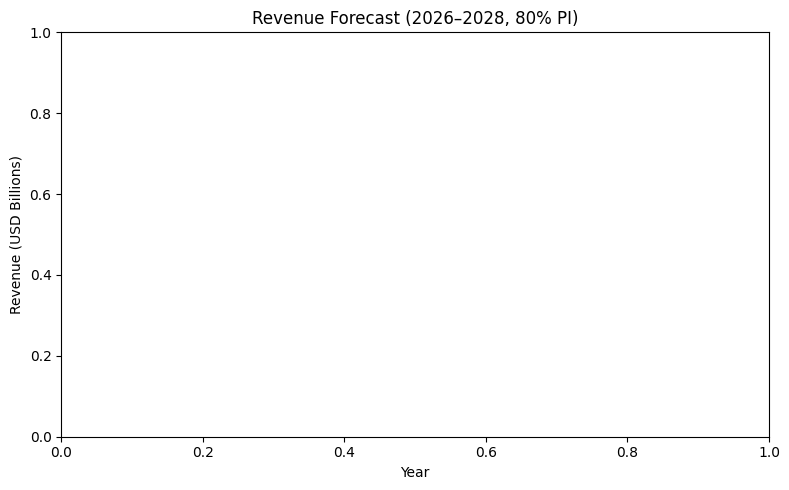

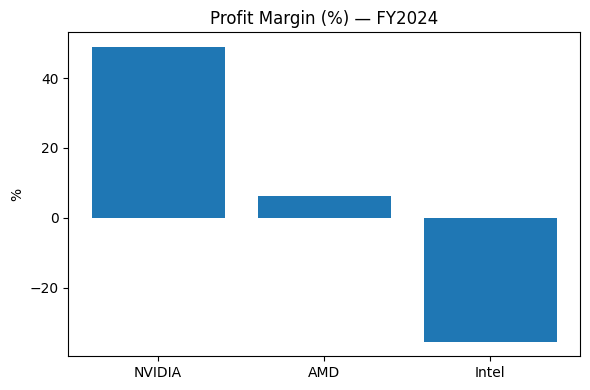

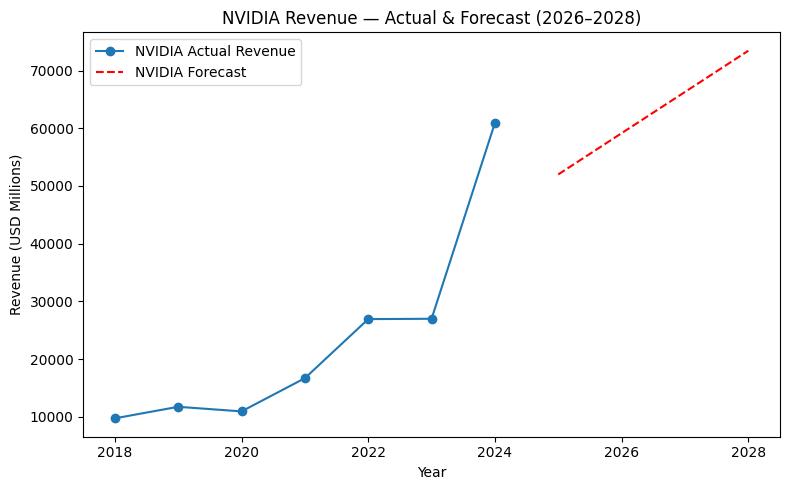

<Figure size 640x480 with 0 Axes>

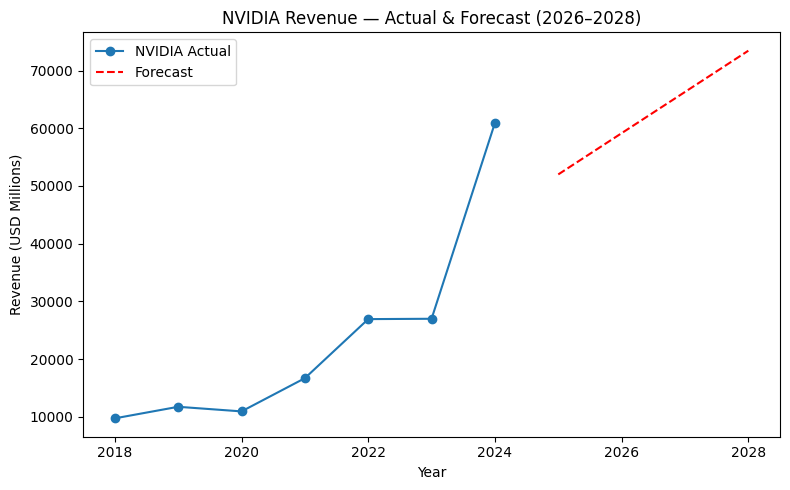

Note: you may need to restart the kernel to use updated packages.
Kernel python: c:\Users\enado\OneDrive\Desktop\Project\venv\Scripts\python.exe
sklearn: 1.7.1
Python: c:\Users\enado\OneDrive\Desktop\Project\venv\Scripts\python.exe
df_sec shape: (21, 5) cols: ['company', 'year', 'revenue', 'net_income', 'profit_margin']


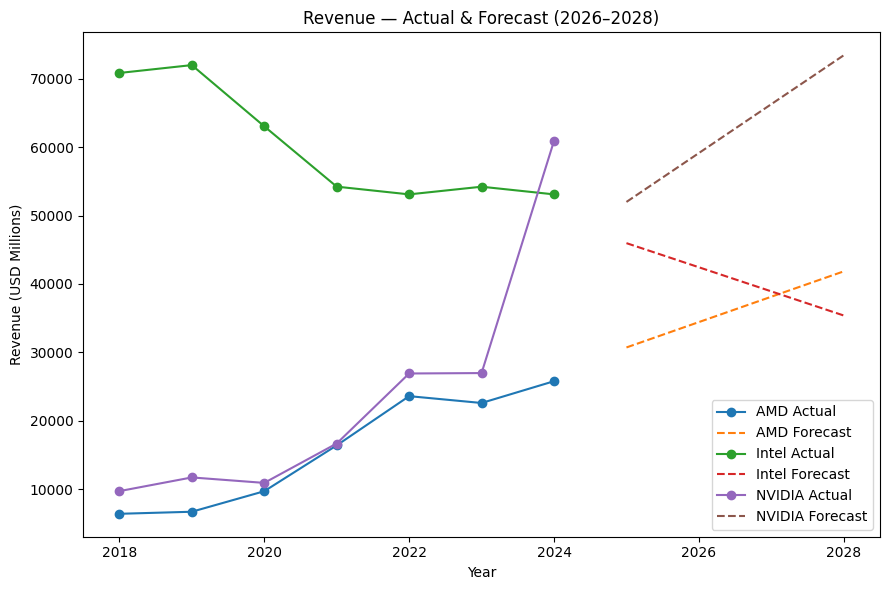

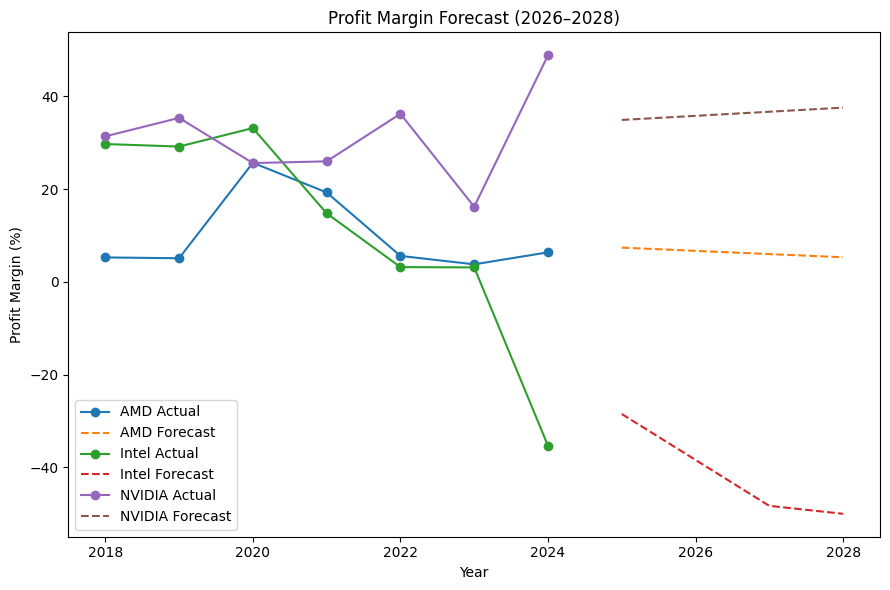

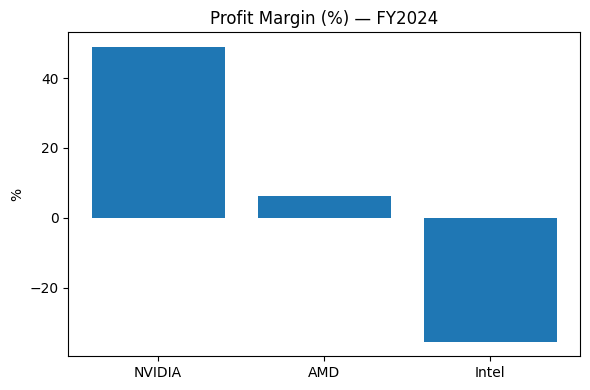

In [129]:
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path
HEADERS = {"User-Agent": "Knight Lin (enado.knight@gmail.com)"}  # ←自分の名前/メールに
FIG_DIR = Path("./figs"); FIG_DIR.mkdir(exist_ok=True)
def fetch_companyfacts(cik: str, cache_dir: Path | None = None, use_cache: bool = True) -> dict:
    """
    SECのcompanyfacts APIから1社ぶんを取得。キャッシュが有効なら保存/再利用。
    """
    cache_dir = cache_dir or Path("./.sec_cache"); cache_dir.mkdir(exist_ok=True)
    cache_file = cache_dir / f"CIK{cik}.json"

    if use_cache and cache_file.exists():
        return json.loads(cache_file.read_text(encoding="utf-8"))

    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()
    if use_cache:
        cache_file.write_text(json.dumps(data), encoding="utf-8")
    return data
def extract_concept_anytag(facts: dict, alias: str, tags: list[str]) -> pd.DataFrame:
    """
    alias: 取りたい概念名（例: 'Revenue'）
    tags: その概念に対応するXBRLタグの候補（優先順で並べる）
    ルール: FY>Q4、10-K>10-K/A>10-Q、同条件は end の最新を採用
    """
    rows = []
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    for tag in tags:
        units = usgaap.get(tag, {}).get("units", {})
        if "USD" not in units:  # 他通貨は除外
            continue
        for item in units["USD"]:
            fy   = item.get("fy")
            fp   = item.get("fp")     # "FY" or "Q1".."Q4"
            form = item.get("form")   # "10-K" / "10-K/A" / "10-Q"...
            end  = item.get("end")
            val  = item.get("val")
            if isinstance(fy, int) and val is not None and form and form.startswith("10-"):
                rows.append({"fy": fy, "end": end, "val": float(val), "fp": fp, "form": form})

    if not rows:
        return pd.DataFrame(columns=["fy", "end", alias])

    df = pd.DataFrame(rows)
    df["end"] = pd.to_datetime(df["end"], errors="coerce")

    # ランキング
    fp_rank = {"FY": 0, "Q4": 1}
    df["fp_rank"] = df["fp"].map(fp_rank).fillna(9)

    def form_rank(f):
        if f == "10-K":   return 0
        if f == "10-K/A": return 1
        if f == "10-Q":   return 2
        return 9
    df["form_rank"] = df["form"].map(form_rank)

    # 年度ごとに1本に絞る（最新endを採用）
    df = (df.sort_values(["fy","fp_rank","form_rank","end"], ascending=[True,True,True,False])
            .drop_duplicates(subset=["fy"], keep="first")
            .sort_values("fy")
            .reset_index(drop=True))

    return df.rename(columns={"val": alias})[["fy", "end", alias]]
CONCEPT_TAGS = {
    "Revenue": [
        "Revenues",
        "RevenueFromContractWithCustomerExcludingAssessedTax",
        "RevenueFromContractWithCustomerIncludingAssessedTax",
        "SalesRevenueNet", "SalesRevenueGoodsNet", "SalesRevenueServicesNet",
    ],
    "NetIncome": ["NetIncomeLoss", "ProfitLoss"],
    "OperatingIncome": ["OperatingIncomeLoss"],
}

def build_company_financials(cik: str, use_cache: bool = True) -> pd.DataFrame:
    facts = fetch_companyfacts(cik, use_cache=use_cache)

    # 個別概念のDFを段階的にマージ（空はスキップ）
    pieces: list[pd.DataFrame] = []
    for alias, tags in CONCEPT_TAGS.items():
        d = extract_concept_anytag(facts, alias, tags)
        if isinstance(d, pd.DataFrame) and not d.empty:
            pieces.append(d)

    if not pieces:
        raise RuntimeError("No facts collected. Check network/User-Agent or tag list.")

    merged = pieces[0].copy()
    for d in pieces[1:]:
        merged = pd.merge(merged, d, on=["fy", "end"], how="outer")

    merged = merged.sort_values("fy").reset_index(drop=True)

    # 派生指標
    if {"Revenue","NetIncome"}.issubset(merged.columns):
        merged["ProfitMargin_%"] = (merged["NetIncome"] / merged["Revenue"]) * 100

    for col in ("Revenue","NetIncome","OperatingIncome"):
        if col in merged.columns:
            merged[f"{col}_YoY_%"] = merged[col].pct_change() * 100

    return merged
COMPANIES = {
    "NVIDIA": "0001045810",
    "AMD":    "0000002488",
    "Intel":  "0000050863",
}

frames = []
for name, cik in COMPANIES.items():
    df1 = build_company_financials(cik, use_cache=True)
    df1["company"] = name
    frames.append(df1)

all_df = pd.concat(frames, ignore_index=True)
cmp = all_df[(all_df["fy"] >= 2018) & (all_df["fy"] <= 2025)].copy()

# 可視化用は欠損を0埋め（計算は元DFで）
cmp_plot = cmp.copy()
cmp_plot["ProfitMargin_%"] = cmp_plot["ProfitMargin_%"].fillna(0)

# 参考: FY2025の元値を確認
cmp.loc[cmp["fy"]==2025, ["company","fy","Revenue","NetIncome","ProfitMargin_%"]]
# (A) 利益率の推移
plt.figure()
for name, sub in cmp_plot.groupby("company"):
    plt.plot(sub["fy"], sub["ProfitMargin_%"], marker="o", label=name)
plt.title("Profit Margin (%) — 2018–2025")
plt.xlabel("Fiscal Year"); plt.ylabel("%"); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"cmp_profit_margin_2018_2025.png", dpi=200)
plt.show()

# (B) 売上（十億ドル換算）
def to_billions(x, pos): return f"{x/1e9:.0f}B"
plt.figure()
ax = plt.gca()
for name, sub in cmp.groupby("company"):
    plt.plot(sub["fy"], sub["Revenue"], marker="o", label=name)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_billions))
plt.title("Revenue (USD, Billions) — 2018–2025")
plt.xlabel("Fiscal Year"); plt.ylabel("USD (Billions)"); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"cmp_revenue_2018_2025.png", dpi=200)
plt.show()

# (C) 最新年（2025）の利益率を横並び
last_year = 2025
snap = cmp_plot[cmp_plot["fy"]==last_year].copy().sort_values("ProfitMargin_%", ascending=False)
plt.figure()
plt.bar(snap["company"], snap["ProfitMargin_%"])
plt.title(f"Profit Margin (%) — FY{last_year}")
plt.ylabel("%"); plt.tight_layout()
plt.savefig(FIG_DIR/f"cmp_profit_margin_FY{last_year}.png", dpi=200)
plt.show()
def cagr(series: pd.Series, years: int) -> float | None:
    s = series.dropna()
    if len(s) < 2 or years < 2 or len(s) < years: return None
    start, end = s.iloc[-years], s.iloc[-1]
    if start == 0: return None
    return (end / start) ** (1/(years-1)) - 1

summary_rows = []
for name, sub in cmp.groupby("company"):
    row = {"company": name}
    row["Avg Profit Margin % (2018–2025)"] = sub["ProfitMargin_%"].mean()
    row["Revenue CAGR (5y) %"] = (cagr(sub["Revenue"], 5) or float("nan")) * 100
    row["Net Income CAGR (5y) %"] = (cagr(sub["NetIncome"], 5) or float("nan")) * 100
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).round(2).sort_values("company").reset_index(drop=True)
summary
def safe_cagr(start, end, years):
    if start <= 0 or end <= 0:
        return None  # 負値だとCAGRが無効
    return (end / start) ** (1 / (years - 1)) - 1

import os
os.makedirs("figures", exist_ok=True)
import matplotlib.pyplot as plt

import pandas as pd

df_sec = pd.read_csv("data/financials_sec.csv")
df_sec["profit_margin"] = 100 * df_sec["net_income"] / df_sec["revenue"]
df_sec.head()
plt.figure(figsize=(8,5))
# …ここに予測の描画コード…
plt.title("Profit Margin Forecast (2026–2028, 80% PI)")
plt.xlabel("Year")
plt.ylabel("Profit Margin (%)")
plt.tight_layout()

plt.savefig("figures/pm_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
# …売上予測コード…
plt.title("Revenue Forecast (2026–2028, 80% PI)")
plt.xlabel("Year")
plt.ylabel("Revenue (USD Billions)")
plt.tight_layout()

plt.savefig("figures/revenue_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

fy2024 = df_sec[df_sec["year"]==2024]

plt.figure(figsize=(6,4))
plt.bar(fy2024["company"], fy2024["profit_margin"])
plt.title("Profit Margin (%) — FY2024")
plt.ylabel("%")
plt.tight_layout()

plt.savefig("figures/pm_fy2025_bar.png", dpi=150, bbox_inches="tight")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

company = "NVIDIA"  # "AMD" や "Intel" でも可
data = df_sec[df_sec["company"]==company].sort_values("year")

X = data["year"].values
y = data["revenue"].values

# 線形回帰モデル (NumPy)
m, b = np.polyfit(X, y, 1)
future_years = np.array([2025, 2026, 2027, 2028])
future_pred = m * future_years + b

# プロット
plt.figure(figsize=(8,5))
plt.plot(X, y, "o-", label=f"{company} Actual Revenue")
plt.plot(future_years, future_pred, "r--", label=f"{company} Forecast")
plt.title(f"{company} Revenue — Actual & Forecast (2026–2028)")
plt.xlabel("Year"); plt.ylabel("Revenue (USD Millions)")
plt.legend(); plt.tight_layout()

import os; os.makedirs("figures", exist_ok=True)
plt.savefig("figures/revenue_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

# 保存
plt.savefig("figures/revenue_forecast.png", dpi=150, bbox_inches="tight")
plt.show()
import numpy as np
import matplotlib.pyplot as plt

company = "NVIDIA"  # "AMD" / "Intel" でも可
g = df_sec[df_sec["company"]==company].sort_values("year")

# 線形回帰（NumPy）
coef = np.polyfit(g["year"].values, g["revenue"].values, 1)  # 1次直線
m, b = coef[0], coef[1]

future_years = np.array([2025, 2026, 2027, 2028])
yhat = m * future_years + b

plt.figure(figsize=(8,5))
plt.plot(g["year"], g["revenue"], "o-", label=f"{company} Actual")
plt.plot(future_years, yhat, "r--", label="Forecast")
plt.title(f"{company} Revenue — Actual & Forecast (2026–2028)")
plt.xlabel("Year"); plt.ylabel("Revenue (USD Millions)")
plt.legend(); plt.tight_layout()

import os; os.makedirs("figures", exist_ok=True)
plt.savefig("figures/revenue_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

%pip install -U scikit-learn
import sklearn, sys
print("Kernel python:", sys.executable)
print("sklearn:", sklearn.__version__)

import sys, pandas as pd, numpy as np, matplotlib.pyplot as plt
print("Python:", sys.executable)
print("df_sec shape:", df_sec.shape, "cols:", list(df_sec.columns))

# 必須列の確認と profit_margin 再計算（保険）
req = {"company","year","revenue","net_income"}
missing = req - set(df_sec.columns)
assert not missing, f"Missing columns: {missing}"
df_sec["profit_margin"] = 100 * df_sec["net_income"] / df_sec["revenue"]

import os; os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(9,6))
for company in ["AMD","Intel","NVIDIA"]:
    g = df_sec[df_sec["company"]==company].dropna(subset=["year","revenue"]).sort_values("year")
    if g.empty: 
        continue
    X = g["year"].to_numpy()
    y = g["revenue"].to_numpy()
    # 実データ
    plt.plot(X, y, "o-", label=f"{company} Actual")
    # 予測（2025–2028）
    future_years = np.array([2025, 2026, 2027, 2028])
    m, b = np.polyfit(X, y, 1)         # 1次回帰
    yhat = m * future_years + b
    plt.plot(future_years, yhat, "--", label=f"{company} Forecast")

plt.title("Revenue — Actual & Forecast (2026–2028)")
plt.xlabel("Year"); plt.ylabel("Revenue (USD Millions)")
plt.legend(); plt.tight_layout()
plt.savefig("figures/revenue_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,6))
for company in ["AMD","Intel","NVIDIA"]:
    g = df_sec[df_sec["company"]==company].dropna(subset=["year","profit_margin"]).sort_values("year")
    if g.empty:
        continue
    X = g["year"].to_numpy()
    y = g["profit_margin"].to_numpy()
    # 実データ
    plt.plot(X, y, "o-", label=f"{company} Actual")
    # 予測（2025–2028）— 直線外挿 & クリップ（研究ノートに注記：model-based, not guidance）
    future_years = np.array([2025, 2026, 2027, 2028])
    m, b = np.polyfit(X, y, 1)
    yhat = m * future_years + b
    yhat = np.clip(yhat, -50, 80)  # 予測が暴れすぎないように
    plt.plot(future_years, yhat, "--", label=f"{company} Forecast")

plt.title("Profit Margin Forecast (2026–2028)")
plt.xlabel("Year"); plt.ylabel("Profit Margin (%)")
plt.legend(); plt.tight_layout()
plt.savefig("figures/pm_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

fy2024 = df_sec[df_sec["year"]==2024].copy()
fy2024["profit_margin"] = 100 * fy2024["net_income"] / fy2024["revenue"]
fy2024 = fy2024.sort_values("profit_margin", ascending=False)

plt.figure(figsize=(6,4))
plt.bar(fy2024["company"], fy2024["profit_margin"])
plt.title("Profit Margin (%) — FY2024")
plt.ylabel("%"); plt.tight_layout()
plt.savefig("figures/pm_fy2025_bar.png", dpi=150, bbox_inches="tight")  # READMEのファイル名に合わせる
plt.show()
